In [22]:
from convml_tt.data.sources.utils.tiler import latlon as latlon_tiler

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import convml_tt

In [8]:
domain_kwargs = dict(
    lat0= 14,
    lon0= -48,
    l_zonal= 3000.0e+3,
    l_meridional= 1000.0e+3
)


In [272]:
import shapely.geometry as geom
import itertools
import numpy as np
import xarray as xr
import matplotlib.patches as mpatches
import warnings

class LocalCartesianDomain:
    def __init__(self, central_latitude, central_longitude, l_meridional, l_zonal):
        self.central_latitude = central_latitude
        self.central_longitude = central_longitude
        self.l_meridional = l_meridional
        self.l_zonal = l_zonal
        
        self.crs = ccrs.LambertAzimuthalEqualArea(central_latitude=central_latitude, central_longitude=central_longitude)

    def get_bounds(self):
        """
        The the spatial distance bounds (in meters) of the tile.
        """
        corners_dir = list(itertools.product([1, -1], [1, -1]))
        corners_dir.insert(0, corners_dir.pop(2))

        corners = np.array([self.l_zonal / 2.0, self.l_meridional / 2.0]) * np.array(corners_dir)

        return corners
    
    def get_grid(self, dx):
        """
        Get an xarray Dataset containing the new lat/lon grid points with their
        position in meters
        """
        x_ = np.arange(-self.l_zonal / 2.0 + dx/2., self.l_zonal / 2 + dx/2.0, dx)
        y_ = np.arange(-self.l_meridional / 2.0 + dx/2., self.l_meridional / 2 + dx/2., dx)
        
        x, y = np.meshgrid(x_, y_, indexing="ij")
        latlon_pts = ccrs.PlateCarree().transform_points(x=x, y=y, src_crs=self.crs, z=np.zeros_like(x))
        
        da_x = xr.DataArray(
            x_,
            attrs=dict(longname="approx distance from center", units="m"),
            dims=("x",),
        )
        da_y = xr.DataArray(
            y_,
            attrs=dict(longname="approx distance from center", units="m"),
            dims=("y",),
        )

        ds = xr.Dataset(coords=dict(x=da_x, y=da_y))

        ds["lon"] = xr.DataArray(
            latlon_pts[..., 0],
            dims=("x", "y"),
            coords=dict(x=ds.x, y=ds.y),
            attrs=dict(standard_name="grid_longitude", units="degree"),
        )
        ds["lat"] = xr.DataArray(
            latlon_pts[..., 1],
            dims=("x", "y"),
            coords=dict(x=ds.x, y=ds.y),
            attrs=dict(standard_name="grid_latitude", units="degree"),
        )
        
        ds.attrs["crs"] = self.crs

        return ds

    def get_grid_extent(self):
        """
        Return grid extent compatible with matplotlib.imshow
        [x0 ,x1, y0, y1] in Cartesian coordinates
        """
        return [
            -self.l_zonal / 2.0,
            self.l_zonal / 2.0,
            -self.l_meridional / 2.0,
            self.l_meridional / 2.0,
        ]

    def plot_outline(self, ax=None, alpha=0.6, **kwargs):
        if ax is None:
            crs = ccrs.PlateCarree()
            fig, ax = plt.subplots(subplot_kw=dict(projection=self.crs), figsize=(10, 6))
            gl = ax.gridlines(linestyle="--", draw_labels=True)
            ax.coastlines(resolution="10m", color="grey")
        else:
            if getattr(ax, "projection") != self.crs:
                warnings.warn(
                    "The outline plot uses a rectangular patch the edges of which"
                    f" are not currently correctly projected unless the {self.crs.__class__.__name__}"
                    " projection is used for the axes"
                )
            pass
        
        bounds_patch = mpatches.Rectangle(
            xy=[-self.l_zonal/2.0, -self.l_meridional/2.0], 
            width=self.l_zonal, height=self.l_meridional,
                                            alpha=alpha,
                                    transform=self.crs,
            **kwargs
        )
        ax.add_patch(bounds_patch)
        return ax

In [273]:
rectile = latlon_tiler.RectTile(**domain_kwargs)
d_kwargs = dict(domain_kwargs)
d_kwargs["central_latitude"] = d_kwargs.pop("lat0")
d_kwargs["central_longitude"] = d_kwargs.pop("lon0")

rectile_new = RectTileNew(**d_kwargs)

In [274]:
rectile.get_bounds()

array([[-62.75226202,  18.08198938],
       [-33.24773798,  18.08198938],
       [-33.81079224,   9.06340296],
       [-62.18920776,   9.06340296]])

In [275]:
rectile_new.get_bounds()

array([[-1500000.,   500000.],
       [ 1500000.,   500000.],
       [ 1500000.,  -500000.],
       [-1500000.,  -500000.]])

/Volumes/agile/tooling/miniconda3/envs/convml_tt/lib/python3.7/site-packages/ipykernel_launcher.py:99: UserWarning: The outline plot uses a rectangular patch the edges of which are not currently correctly projected unless the LambertAzimuthalEqualArea projection is used


(-48.00000000000001, 14.0)
(-34.22074344940813, 9.108599851860415)
(-48.00000000000001, 14.0)
(-34.22074344940813, 9.108599851860415)


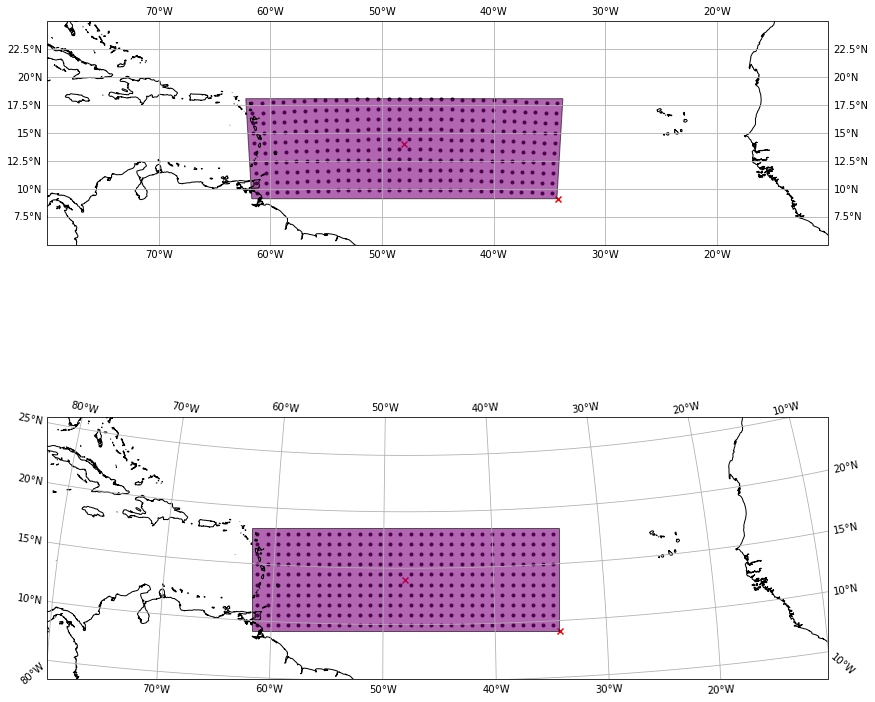

In [277]:
fig = plt.figure(figsize=(14, 14))

ax1 = fig.add_subplot(211, projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(212, projection=rectile_new.crs)
#ax3 = fig.add_subplot(223, projection=ccrs.AlbersEqualArea())


pts = [
    (0.0, 0.0), (domain_kwargs["l_zonal"]/2., -domain_kwargs["l_meridional"]/2.)
]
crs_ref = ccrs.Orthographic(
    central_latitude=domain_kwargs["lat0"], central_longitude=domain_kwargs["lon0"]
)

crs_dst = ccrs.PlateCarree()

axes = [ax1, ax2, ]

for ax in axes:

    #ax = rectile.plot_outline(ax=ax)

    rectile_new.plot_outline(ax=ax, color="red")

    for pt in pts:
        pt_latlon = crs_dst.transform_point(*pt, src_crs=crs_ref)
        print(pt_latlon)
        ax.scatter(*pt_latlon, marker='x', color="red", transform=ccrs.PlateCarree())

    da_grid = rectile_new.get_grid(dx=100.0e3)

    #ax.scatter(da_grid.lon, da_grid.lat, marker='+', transform=ccrs.PlateCarree())

    ax.scatter(*xr.broadcast(da_grid.x, da_grid.y), marker='.', transform=da_grid.crs, color="black")


for ax in axes:
    ax.set_extent([-80, -10, 5, 25], crs=ccrs.PlateCarree())



for ax in axes:
    ax.gridlines(draw_labels=True)
    ax.coastlines(resolution="10m")


In [255]:
ax.projection